In [1]:
### load the required libraries
import wrds
import math
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt  
plt.style.use('seaborn')  
mpl.rcParams['font.family'] = 'serif'  
%matplotlib inline

import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def isid(data,variables):      ### This function is commonly used in data analysis, suggest to define it in the first script
    dup=data.duplicated(variables,keep=False)
    if True in dup.values:
        print(str(variables)+" Do NOT uniquely identify this dataset") 
    else:
        print(str(variables)+" uniquely identify this dataset")

perc=[0.01,0.05,0.25,0.5,0.75,0.9,0.95,0.99] # this list is often used in summary stats

## &#9989;  <font color=red>**Question 1:**</font>  Use `ashares2.csv`, which contains the daily closing price of 108 A shares from 2018 to first half year of 2019. Find out all the pairs that the log closing prices are cointegrated at 99% confidence level.


In [2]:
ashares = pd.read_csv('ashares2.csv')
ashares

,Unnamed: 0,id,date,prc
0,0,1,2018-01-02,13.70
1,1,1,2018-01-03,13.33
2,2,1,2018-01-04,13.25
3,3,1,2018-01-05,13.30
4,4,1,2018-01-08,12.96
...,...,...,...,...
38983,38983,612,2019-06-24,5.56
38984,38984,612,2019-06-25,5.33
38985,38985,612,2019-06-26,5.29
38986,38986,612,2019-06-27,5.28


In [3]:
ashares.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38988 entries, 0 to 38987
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  38988 non-null  int64  
 1   id          38988 non-null  int64  
 2   date        38988 non-null  object 
 3   prc         38988 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 1.2+ MB


In [4]:
isid(ashares,['id','date'])

['id', 'date'] uniquely identify this dataset


In [5]:
ashares.describe(percentiles=perc)

,Unnamed: 0,id,prc
count,38988.000000,38988.000000,38988.000000
mean,19493.500000,344.305556,10.441578
std,11255.010484,232.236516,11.996681
min,0.000000,1.000000,1.680000
1%,389.870000,2.000000,2.700000
5%,1949.350000,12.000000,3.333500
25%,9746.750000,67.500000,4.810000
50%,19493.500000,426.500000,6.770000
75%,29240.250000,548.500000,10.350000
90%,35088.300000,591.000000,18.420000


#### Step1. Calculate the log of prices

In [6]:
ashares['logprice'] = np.log(np.abs(ashares['prc']))
csi = ashares[['id', 'date', 'logprice']]
csi.dropna(inplace = True)
csi

/Users/zoechan/anaconda3/envs/python3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,id,date,logprice
0,1,2018-01-02,2.617396
1,1,2018-01-03,2.590017
2,1,2018-01-04,2.583998
3,1,2018-01-05,2.587764
4,1,2018-01-08,2.561868
...,...,...,...
38983,612,2019-06-24,1.715598
38984,612,2019-06-25,1.673351
38985,612,2019-06-26,1.665818
38986,612,2019-06-27,1.663926


In [7]:
csi.id.value_counts() ##108 A shares

607    361
554    361
582    361
423    361
519    361
      ... 
598    361
23     361
55     361
407    361
96     361
Name: id, Length: 108, dtype: int64

#### Step 2a. Construct the potential (108/2)*107 pairs and examine the cointegration for one pair as an example.

In [8]:
csi['id'].unique()

array([  1,   2,   5,   9,  11,  12,  14,  16,  17,  20,  21,  23,  25,
        26,  27,  28,  30,  36,  40,  49,  50,  55,  58,  59,  60,  65,
        66,  68,  69,  70,  78,  89,  90,  96,  99, 100, 150, 153, 157,
       159, 166, 338, 400, 402, 404, 407, 411, 413, 416, 417, 419, 421,
       423, 425, 428, 429, 430, 488, 498, 501, 505, 507, 513, 514, 518,
       519, 520, 524, 525, 528, 529, 530, 531, 532, 536, 537, 539, 541,
       544, 546, 548, 550, 551, 552, 553, 554, 559, 560, 561, 565, 567,
       568, 570, 573, 581, 582, 589, 591, 596, 597, 598, 599, 601, 605,
       607, 609, 610, 612])

In [9]:
import itertools
comb = pd.DataFrame(list(itertools.combinations(csi['id'].unique(), 2)), columns = ['X1', 'X2'])
comb # 5778 combinations

,X1,X2
0,1,2
1,1,5
2,1,9
3,1,11
4,1,12
...,...,...
5773,607,610
5774,607,612
5775,609,610
5776,609,612


#### Step 2.b Get Johansen Cointegration Test Statistics and Critical values

#### We use the function `coint_johansen` to test cointegration for a matrix with each column being a time series.


"""
    Johansen cointegration test of the cointegration rank of a VECM

    Parameters
    ----------
    endog : array_like (nobs_tot x neqs)
        Data to test
    det_order : int
        * -1 - no deterministic terms - model1
        * 0 - constant term - model3
        * 1 - linear trend
    k_ar_diff : int, nonnegative
        Number of lagged differences in the model.
"""

+ See https://www.statsmodels.org/stable/generated/statsmodels.tsa.vector_ar.vecm.coint_johansen.html for more details

+ In our case of **two series**, the null hpyothesis is that there are no cointegration between the two series 

+ jres.cvt[0] produce the 90%, 95%, and 99% critical values of the test statistics

+ jres.lr1[0] produces the test statistics: reject the null hypothesis if this is greater than some 5% or 1% thresholds from jres.cvt[0]

In [10]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
def jtest(pair):
#     df = csi.loc[csi['id'].isin([pair[0], pair[1]])].pivot(index = 'date', columns = 'id')  ##Return reshaped DataFrame organized by given index / column values.
    df = csi.loc[csi['id'].isin([pair[0], pair[1]])].set_index(['date','id']).unstack()
    jres = coint_johansen(df.to_numpy(), 1, 0)
    return np.append(pair, np.append(jres.lr1[0],jres.cvt[0]))

+ https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pivot.html

In [11]:
###Test the self-defined function with the 1st pair
pair = comb.to_numpy()[0]
print(jtest(pair))

[ 1.          2.          9.16558672 16.1619     18.3985     23.1485    ]


#### Step 3. Use for loop to generate the stats for all pairs

In [12]:
stat_all = [jtest(pair).tolist()  for pair in comb.to_numpy()]
stat_all = pd.DataFrame(stat_all, columns = ['stock 1', 'stock 2', 'stat', 'pct10', 'pct5', 'pct1'])
stat_all

,stock 1,stock 2,stat,pct10,pct5,pct1
0,1.0,2.0,9.165587,16.1619,18.3985,23.1485
1,1.0,5.0,12.193672,16.1619,18.3985,23.1485
2,1.0,9.0,8.085612,16.1619,18.3985,23.1485
3,1.0,11.0,10.373378,16.1619,18.3985,23.1485
4,1.0,12.0,9.192283,16.1619,18.3985,23.1485
...,...,...,...,...,...,...
5773,607.0,610.0,29.738969,16.1619,18.3985,23.1485
5774,607.0,612.0,13.427331,16.1619,18.3985,23.1485
5775,609.0,610.0,17.307009,16.1619,18.3985,23.1485
5776,609.0,612.0,11.704061,16.1619,18.3985,23.1485


#### Step 4. Select all the pairs that the log closing prices are cointegrated at 99% confidence level.

In [13]:
## To reject the null hypothesis if stat greater 1% critical value
stat_all.sort_values(by = 'stat').loc[stat_all['stat'] > stat_all['pct1']]

,stock 1,stock 2,stat,pct10,pct5,pct1
5234,536.0,570.0,23.153121,16.1619,18.3985,23.1485
2250,59.0,520.0,23.161315,16.1619,18.3985,23.1485
803,16.0,552.0,23.166469,16.1619,18.3985,23.1485
1579,28.0,582.0,23.183144,16.1619,18.3985,23.1485
1455,27.0,514.0,23.187943,16.1619,18.3985,23.1485
...,...,...,...,...,...,...
5474,551.0,607.0,45.180665,16.1619,18.3985,23.1485
1724,36.0,501.0,46.316512,16.1619,18.3985,23.1485
4792,514.0,525.0,49.255974,16.1619,18.3985,23.1485
314,5.0,607.0,53.985439,16.1619,18.3985,23.1485


## &#9989;  <font color=red>**Question 2:**</font>  Calculate the log price spread of the most significantly cointegrated paired stocks you found in question 1. Is the spread stationary? Construct pair trading strategy and calculate the cumulative returns.

(Pair trading strategy: Define $Spread_t=logY_t−(\alpha+\beta logX_t)$. If Spreadt is greater than standard deviation of the spread, then buy $\beta$ shares X and sell one share of Y at $t$, and Vice versa.)



#### Step1. Select the pair with highest statistic

In [14]:
copair = stat_all.loc[stat_all['stat'] == stat_all['stat'].max(), ['stock 1', 'stock 2']].values.tolist()[0]
copair

[413.0, 529.0]

Prepare the prices for the cointegrated pair for the construction of trading strategy.

In [15]:
# goodpair = csi.loc[csi['id'].isin([copair[0], copair[1]])].pivot(index = 'date', columns = 'id', values = 'logprice')
goodpair = csi.loc[csi['id'].isin([copair[0], copair[1]])].set_index(['date','id']).unstack()
goodpair

logprice          
id               413       529
date                          
2018-01-02  2.254445  1.927164
2018-01-03  2.259678  1.934416
2018-01-04  2.272126  1.935860
2018-01-05  2.259678  1.955860
2018-01-08  2.255493  1.948763
...              ...       ...
2019-06-24  1.654411  1.793425
2019-06-25  1.642873  1.781709
2019-06-26  1.638997  1.783391
2019-06-27  1.644805  1.796747
2019-06-28  1.637053  1.780024

[361 rows x 2 columns]

#### Step 2. Estimate the Hedge Ratio using Linear Regression, and get the Spread

+ Spreadt=logYt−(α+βlogXt)

In [16]:
model = sm.OLS(goodpair.iloc[:,0], sm.add_constant(goodpair.iloc[:,1]))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      ('logprice', 413)   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.553
Method:                 Least Squares   F-statistic:                     447.2
Date:                Wed, 16 Dec 2020   Prob (F-statistic):           4.84e-65
Time:                        17:05:28   Log-Likelihood:                 182.18
No. Observations:                 361   AIC:                            -360.4
Df Residuals:                     359   BIC:                            -352.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0536      0.088     -0.609      0.543      -0.227       0.119
('logprice', 529)     1.0604      0.050     21.147      0.000       0.962       1.159
==============================================================================
Omnibus:                       24.147   Durbin-Watson:                   0.042
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               13.625
Skew:                          -0.314   Prob(JB):                      0.00110
Kurtosis:                       2.285   Cond. No.                         26.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

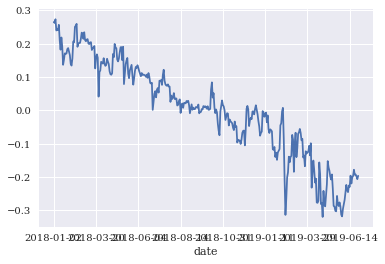

In [17]:
goodpair['spread'] = results.resid
goodpair['spread'].plot()
plt.show()

+ Compared with the chart of L5_Python_Cointegration, you should be able to see the difference of stationary data set and non-stationary data set

#### Step 3. Run Augmented Dickey-Fuller test to check the stationarity of the Residuals

In [18]:
result = sm.tsa.stattools.adfuller(goodpair['spread'])

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.023645
p-value: 0.744543
	1%: -3.449
	5%: -2.870
	10%: -2.571


+ The Statistic is greater than the critical values, therefore, we can't reject the null hypothesis, which means the residuals might be non-stationary

+ The null hpyothesis of ADF is that there is unit root in the series, therefore, rejecting it indicates that the series is stationary

#### Step 4. Calculate the Standard Deviation of the spread

+ a. The residuals is not stationary, so we can't assume that they follow Gaussian/Normal Distribution
+ b. There is no need to assume that it follows certain distribution to create the signal; since the signal is based on the standard deviation of the spread and the spread itself as specified in the question

In [19]:
sigma=goodpair['spread'].std()
sigma

0.14628269675997257

#### Step 5. Create Trading Signal

If $\log(Y)−\alpha−\beta \log(X)>sigma$, buy $\beta$ shares of $X$ and sell $1$ share of $Y$, instead, buy $1$ share of $Y$ and sell $\beta$ shares of $X$.

If buy $1$ share of $Y$ and sell $\beta$ shares of $X$, the portfolio value at $t$ is
$$\log(Y_t)−\beta \times \log(X_t)=\mbox{spread}_t+\alpha$$

If buy $1$ share of $Y$ and sell $\beta$ shares of $X$, the portfolio value at t+1 is
$$\log(Y_{t+1})−\beta \times \log(X_{t+1})=\mbox{spread}_{t+1}+\alpha$$

The return from $t$ to $t+1$ is
$$\mbox{spread}_{t+1}−\mbox{spread}_t$$

+ a. If $\log(Y)−\alpha−\beta \log(X)>sigma$ at time t, it means that stock Y price is higher than the regression indicates for time t, then it should fall back at time t+1
+ b. Buy $\beta$ shares of $X$ and sell $1$ share of $Y$ at time t should gain profits from t to t+1 

In [20]:
goodpair['signal'] = 2*(goodpair['spread'] < sigma).astype(int) - 1
goodpair

logprice              spread signal
id               413       529                 
date                                           
2018-01-02  2.254445  1.927164  0.264555     -1
2018-01-03  2.259678  1.934416  0.262099     -1
2018-01-04  2.272126  1.935860  0.273016     -1
2018-01-05  2.259678  1.955860  0.239359     -1
2018-01-08  2.255493  1.948763  0.242701     -1
...              ...       ...       ...    ...
2019-06-24  1.654411  1.793425 -0.193663      1
2019-06-25  1.642873  1.781709 -0.192779      1
2019-06-26  1.638997  1.783391 -0.198438      1
2019-06-27  1.644805  1.796747 -0.206792      1
2019-06-28  1.637053  1.780024 -0.196812      1

[361 rows x 4 columns]

In [21]:
goodpair['ret'] = goodpair['spread'] - goodpair['spread'].shift(1)
goodpair

logprice              spread signal       ret
id               413       529                           
date                                                     
2018-01-02  2.254445  1.927164  0.264555     -1       NaN
2018-01-03  2.259678  1.934416  0.262099     -1 -0.002457
2018-01-04  2.272126  1.935860  0.273016     -1  0.010917
2018-01-05  2.259678  1.955860  0.239359     -1 -0.033657
2018-01-08  2.255493  1.948763  0.242701     -1  0.003342
...              ...       ...       ...    ...       ...
2019-06-24  1.654411  1.793425 -0.193663      1 -0.015061
2019-06-25  1.642873  1.781709 -0.192779      1  0.000884
2019-06-26  1.638997  1.783391 -0.198438      1 -0.005660
2019-06-27  1.644805  1.796747 -0.206792      1 -0.008354
2019-06-28  1.637053  1.780024 -0.196812      1  0.009981

[361 rows x 5 columns]

In [22]:
goodpair['ret_signal'] = goodpair['signal'].shift(1)*goodpair['ret']
goodpair

logprice              spread signal       ret ret_signal
id               413       529                                      
date                                                                
2018-01-02  2.254445  1.927164  0.264555     -1       NaN        NaN
2018-01-03  2.259678  1.934416  0.262099     -1 -0.002457   0.002457
2018-01-04  2.272126  1.935860  0.273016     -1  0.010917  -0.010917
2018-01-05  2.259678  1.955860  0.239359     -1 -0.033657   0.033657
2018-01-08  2.255493  1.948763  0.242701     -1  0.003342  -0.003342
...              ...       ...       ...    ...       ...        ...
2019-06-24  1.654411  1.793425 -0.193663      1 -0.015061  -0.015061
2019-06-25  1.642873  1.781709 -0.192779      1  0.000884   0.000884
2019-06-26  1.638997  1.783391 -0.198438      1 -0.005660  -0.005660
2019-06-27  1.644805  1.796747 -0.206792      1 -0.008354  -0.008354
2019-06-28  1.637053  1.780024 -0.196812      1  0.009981   0.009981

[361 rows x 6 columns]

In [23]:
 #As we are using log returns, simply use sum to get cumulative returns
goodpair['cumret']=goodpair['ret_signal'].cumsum()
goodpair

logprice              spread signal       ret ret_signal    cumret
id               413       529                                                
date                                                                          
2018-01-02  2.254445  1.927164  0.264555     -1       NaN        NaN       NaN
2018-01-03  2.259678  1.934416  0.262099     -1 -0.002457   0.002457  0.002457
2018-01-04  2.272126  1.935860  0.273016     -1  0.010917  -0.010917 -0.008460
2018-01-05  2.259678  1.955860  0.239359     -1 -0.033657   0.033657  0.025196
2018-01-08  2.255493  1.948763  0.242701     -1  0.003342  -0.003342  0.021855
...              ...       ...       ...    ...       ...        ...       ...
2019-06-24  1.654411  1.793425 -0.193663      1 -0.015061  -0.015061  0.423205
2019-06-25  1.642873  1.781709 -0.192779      1  0.000884   0.000884  0.424089
2019-06-26  1.638997  1.783391 -0.198438      1 -0.005660  -0.005660  0.418430
2019-06-27  1.644805  1.796747 -0.206792      1 -0.008354  -0.008354  0.410076
2019-06-28  1.637053  1.780024 -0.196812      1  0.009981   0.009981  0.420056

[361 rows x 7 columns]

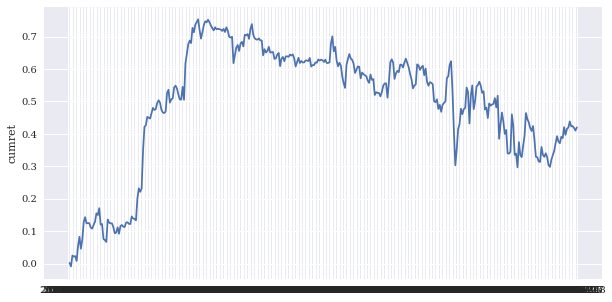

In [24]:
plt.figure(figsize=[10,5])
plt.plot(goodpair['cumret'])
plt.ylabel('cumret')
plt.show()

## &#9989;  <font color=red>**Question 3:**</font>   Construct the strategy with AR(1) and MA(1) assumptions on the spread process. Calculate the cumulative returns.

#### Part 1. Model the Spread as AR(1) process.

Trading strategy: 
+ If the realised spread at time t is much higher than the predicted spread by using the spread at time t-1, $Y$ is too expensive at time t, or $X$ is too cheap at time t. 
+ If $\mbox{Spread}_t−\mathbf{E}(\mbox{Spread}_t|F_{t-1})>sigma$, buy $\beta$ shares of $X$ and sell $1$ share of $Y$, instead, buy $1$ share of $Y$ and sell $\beta$ shares of $X$.
+ $Sigma$ here is the Mean Standand Error of AR(1) Model

AR(1) Model:

$$\mbox{Spread}_t=\theta \mbox{Spread}_{t−1}+\epsilon_t$$
with $\epsilon_t\approx \mathcal{N}(0,\sigma^2)$

+ The intercept of this AR process is $0$ since the $\mbox{Spread}_t$ is constructed from regression. If there is an intercept other than $0$, then it should be included in the $\alpha$ term of the regression of $\log(Y)=\alpha+\beta \log(X)$+spread

1-step forcast of AR(1) Model:

+ 1-step forcast of the $\mathbf{E}(\mbox{Spread}_{t+1}|F_t): \mathbf{E}(\mbox{Spread}_{t+1}|F_t)=\theta\times \mbox{Spread}t$

In [25]:
model_AR = sm.tsa.arima.ARIMA(goodpair['spread'], trend = 'n', order=(1, 0, 0), missing = 'drop', enforce_stationarity= False)
model_AR_fit = model_AR.fit()
model_AR_fit.summary()

/Users/zoechan/anaconda3/envs/python3.7.4/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/zoechan/anaconda3/envs/python3.7.4/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/zoechan/anaconda3/envs/python3.7.4/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 spread   No. Observations:                  361
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 752.256
Date:                Wed, 16 Dec 2020   AIC                          -1500.512
Time:                        17:05:32   BIC                          -1492.740
Sample:                             0   HQIC                         -1497.422
                                - 361                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9766      0.010     99.453      0.000       0.957       0.996
sigma2         0.0009   3.92e-05     22.871      0.000       0.001       0.001
===================================================================================
Ljung-Box (Q):                       63.22   Jarque-Bera (JB):               245.54
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               2.09   Skew:                            -0.82
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [26]:
print('The sigma_AR is %.4f' %np.sqrt(model_AR_fit.mse))

The sigma_AR is 0.0330


In [27]:
goodpair['signal_AR'] = 2*(goodpair['spread'] - goodpair['spread'].shift(1)*model_AR_fit.params[0] < np.sqrt(model_AR_fit.mse)) - 1
goodpair

logprice              spread signal       ret ret_signal  \
id               413       529                                         
date                                                                   
2018-01-02  2.254445  1.927164  0.264555     -1       NaN        NaN   
2018-01-03  2.259678  1.934416  0.262099     -1 -0.002457   0.002457   
2018-01-04  2.272126  1.935860  0.273016     -1  0.010917  -0.010917   
2018-01-05  2.259678  1.955860  0.239359     -1 -0.033657   0.033657   
2018-01-08  2.255493  1.948763  0.242701     -1  0.003342  -0.003342   
...              ...       ...       ...    ...       ...        ...   
2019-06-24  1.654411  1.793425 -0.193663      1 -0.015061  -0.015061   
2019-06-25  1.642873  1.781709 -0.192779      1  0.000884   0.000884   
2019-06-26  1.638997  1.783391 -0.198438      1 -0.005660  -0.005660   
2019-06-27  1.644805  1.796747 -0.206792      1 -0.008354  -0.008354   
2019-06-28  1.637053  1.780024 -0.196812      1  0.009981   0.009981   

              cumret signal_AR  
id                              
date                            
2018-01-02       NaN        -1  
2018-01-03  0.002457         1  
2018-01-04 -0.008460         1  
2018-01-05  0.025196         1  
2018-01-08  0.021855         1  
...              ...       ...  
2019-06-24  0.423205         1  
2019-06-25  0.424089         1  
2019-06-26  0.418430         1  
2019-06-27  0.410076         1  
2019-06-28  0.420056         1  

[361 rows x 8 columns]

In [28]:
##Alternative to create signal 
goodpair['signal_AR_pre'] = 2*(goodpair['spread'] - model_AR_fit.predict() < np.sqrt(model_AR_fit.mse)) - 1
goodpair

logprice              spread signal       ret ret_signal  \
id               413       529                                         
date                                                                   
2018-01-02  2.254445  1.927164  0.264555     -1       NaN        NaN   
2018-01-03  2.259678  1.934416  0.262099     -1 -0.002457   0.002457   
2018-01-04  2.272126  1.935860  0.273016     -1  0.010917  -0.010917   
2018-01-05  2.259678  1.955860  0.239359     -1 -0.033657   0.033657   
2018-01-08  2.255493  1.948763  0.242701     -1  0.003342  -0.003342   
...              ...       ...       ...    ...       ...        ...   
2019-06-24  1.654411  1.793425 -0.193663      1 -0.015061  -0.015061   
2019-06-25  1.642873  1.781709 -0.192779      1  0.000884   0.000884   
2019-06-26  1.638997  1.783391 -0.198438      1 -0.005660  -0.005660   
2019-06-27  1.644805  1.796747 -0.206792      1 -0.008354  -0.008354   
2019-06-28  1.637053  1.780024 -0.196812      1  0.009981   0.009981   

              cumret signal_AR signal_AR_pre  
id                                            
date                                          
2018-01-02       NaN        -1            -1  
2018-01-03  0.002457         1             1  
2018-01-04 -0.008460         1             1  
2018-01-05  0.025196         1             1  
2018-01-08  0.021855         1             1  
...              ...       ...           ...  
2019-06-24  0.423205         1             1  
2019-06-25  0.424089         1             1  
2019-06-26  0.418430         1             1  
2019-06-27  0.410076         1             1  
2019-06-28  0.420056         1             1  

[361 rows x 9 columns]

In [29]:
###Check if the signals are the same 
any(goodpair['signal_AR_pre']!=goodpair['signal_AR'])

False

In [30]:
goodpair['ret_AR'] = goodpair['signal_AR_pre'].shift(1)*goodpair['ret']
goodpair

logprice              spread signal       ret ret_signal  \
id               413       529                                         
date                                                                   
2018-01-02  2.254445  1.927164  0.264555     -1       NaN        NaN   
2018-01-03  2.259678  1.934416  0.262099     -1 -0.002457   0.002457   
2018-01-04  2.272126  1.935860  0.273016     -1  0.010917  -0.010917   
2018-01-05  2.259678  1.955860  0.239359     -1 -0.033657   0.033657   
2018-01-08  2.255493  1.948763  0.242701     -1  0.003342  -0.003342   
...              ...       ...       ...    ...       ...        ...   
2019-06-24  1.654411  1.793425 -0.193663      1 -0.015061  -0.015061   
2019-06-25  1.642873  1.781709 -0.192779      1  0.000884   0.000884   
2019-06-26  1.638997  1.783391 -0.198438      1 -0.005660  -0.005660   
2019-06-27  1.644805  1.796747 -0.206792      1 -0.008354  -0.008354   
2019-06-28  1.637053  1.780024 -0.196812      1  0.009981   0.009981   

              cumret signal_AR signal_AR_pre    ret_AR  
id                                                      
date                                                    
2018-01-02       NaN        -1            -1       NaN  
2018-01-03  0.002457         1             1  0.002457  
2018-01-04 -0.008460         1             1  0.010917  
2018-01-05  0.025196         1             1 -0.033657  
2018-01-08  0.021855         1             1  0.003342  
...              ...       ...           ...       ...  
2019-06-24  0.423205         1             1 -0.015061  
2019-06-25  0.424089         1             1  0.000884  
2019-06-26  0.418430         1             1 -0.005660  
2019-06-27  0.410076         1             1 -0.008354  
2019-06-28  0.420056         1             1  0.009981  

[361 rows x 10 columns]

In [31]:
goodpair['cumret_AR']=goodpair['ret_AR'].cumsum()
goodpair

logprice              spread signal       ret ret_signal  \
id               413       529                                         
date                                                                   
2018-01-02  2.254445  1.927164  0.264555     -1       NaN        NaN   
2018-01-03  2.259678  1.934416  0.262099     -1 -0.002457   0.002457   
2018-01-04  2.272126  1.935860  0.273016     -1  0.010917  -0.010917   
2018-01-05  2.259678  1.955860  0.239359     -1 -0.033657   0.033657   
2018-01-08  2.255493  1.948763  0.242701     -1  0.003342  -0.003342   
...              ...       ...       ...    ...       ...        ...   
2019-06-24  1.654411  1.793425 -0.193663      1 -0.015061  -0.015061   
2019-06-25  1.642873  1.781709 -0.192779      1  0.000884   0.000884   
2019-06-26  1.638997  1.783391 -0.198438      1 -0.005660  -0.005660   
2019-06-27  1.644805  1.796747 -0.206792      1 -0.008354  -0.008354   
2019-06-28  1.637053  1.780024 -0.196812      1  0.009981   0.009981   

              cumret signal_AR signal_AR_pre    ret_AR cumret_AR  
id                                                                
date                                                              
2018-01-02       NaN        -1            -1       NaN       NaN  
2018-01-03  0.002457         1             1  0.002457  0.002457  
2018-01-04 -0.008460         1             1  0.010917  0.013374  
2018-01-05  0.025196         1             1 -0.033657 -0.020283  
2018-01-08  0.021855         1             1  0.003342 -0.016941  
...              ...       ...           ...       ...       ...  
2019-06-24  0.423205         1             1 -0.015061 -0.131819  
2019-06-25  0.424089         1             1  0.000884 -0.130934  
2019-06-26  0.418430         1             1 -0.005660 -0.136594  
2019-06-27  0.410076         1             1 -0.008354 -0.144948  
2019-06-28  0.420056         1             1  0.009981 -0.134967  

[361 rows x 11 columns]

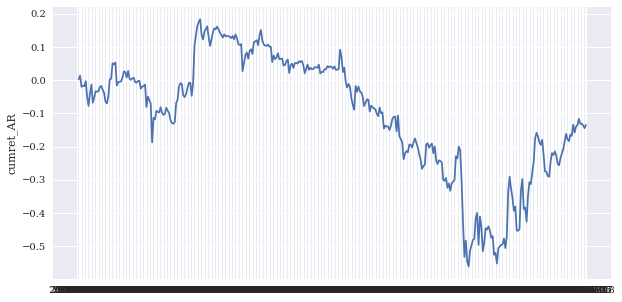

In [32]:
plt.figure(figsize=[10,5])
plt.plot(goodpair['cumret_AR'])
plt.ylabel('cumret_AR')
plt.show()

#### Part 2. Model the Spread as MA(1) process.

Trading strategy: 
+ If the realised spread at time t is much higher than the predicted spread by using the spread at time t-1, $Y$ is too expensive at time t, or $X$ is too cheap at time t. 
+ If $\mbox{Spread}_t−\mathbf{E}(\mbox{Spread}_t|F_{t-1})>sigma$, buy $\beta$ shares of $X$ and sell $1$ share of $Y$, instead, buy $1$ share of $Y$ and sell $\beta$ shares of $X$.
+ $Sigma$ here is the Mean Standand Error of MA(1) Model

MA(1) Model:
$$\mbox{Spread}_t=\epsilon_t+\theta_1\epsilon_{t−1}$$
with $\epsilon_i\approx \mathcal{N}(0,\sigma^2)$

+ The intercept of this MA process is $0$ since the $\mbox{Spread}_t$ is constructed from regression. If there is an intercept other than $0$, then it should be included in the $\alpha$ term of the regression of $\log(Y)=\alpha+\beta \log(X)$+spread

1-step forcast of MA(1) Model:

+ 1-step forcast of the $\mathbf{E}(\mbox{Spread}_{t+1}|F_t): \mathbf{E}(\mbox{Spread}_{t+1}|F_t)=\theta_1\epsilon_{t−1}$

In [33]:
model_MA = sm.tsa.arima.ARIMA(goodpair['spread'], trend = 'n', order=(0, 0, 1), missing = 'drop', enforce_stationarity= False)
model_MA_fit = model_MA.fit()
model_MA_fit.summary()

/Users/zoechan/anaconda3/envs/python3.7.4/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/zoechan/anaconda3/envs/python3.7.4/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/zoechan/anaconda3/envs/python3.7.4/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 spread   No. Observations:                  361
Model:                 ARIMA(0, 0, 1)   Log Likelihood                 376.379
Date:                Wed, 16 Dec 2020   AIC                           -748.757
Time:                        17:05:36   BIC                           -740.990
Sample:                             0   HQIC                          -745.669
                                - 361                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.8470      0.024     34.943      0.000       0.799       0.894
sigma2         0.0072      0.001     12.053      0.000       0.006       0.008
===================================================================================
Ljung-Box (Q):                     6695.22   Jarque-Bera (JB):                 7.15
Prob(Q):                              0.00   Prob(JB):                         0.03
Heteroskedasticity (H):               1.28   Skew:                            -0.31
Prob(H) (two-sided):                  0.17   Kurtosis:                         2.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [34]:
print('The sigma_MA is %.4f' %np.sqrt(model_MA_fit.mse))

The sigma_MA is 0.0873


In [35]:
goodpair['signal_MA'] = 2*(goodpair['spread']-model_MA_fit.predict() <np.sqrt(model_MA_fit.mse)) - 1
goodpair

logprice              spread signal       ret ret_signal  \
id               413       529                                         
date                                                                   
2018-01-02  2.254445  1.927164  0.264555     -1       NaN        NaN   
2018-01-03  2.259678  1.934416  0.262099     -1 -0.002457   0.002457   
2018-01-04  2.272126  1.935860  0.273016     -1  0.010917  -0.010917   
2018-01-05  2.259678  1.955860  0.239359     -1 -0.033657   0.033657   
2018-01-08  2.255493  1.948763  0.242701     -1  0.003342  -0.003342   
...              ...       ...       ...    ...       ...        ...   
2019-06-24  1.654411  1.793425 -0.193663      1 -0.015061  -0.015061   
2019-06-25  1.642873  1.781709 -0.192779      1  0.000884   0.000884   
2019-06-26  1.638997  1.783391 -0.198438      1 -0.005660  -0.005660   
2019-06-27  1.644805  1.796747 -0.206792      1 -0.008354  -0.008354   
2019-06-28  1.637053  1.780024 -0.196812      1  0.009981   0.009981   

              cumret signal_AR signal_AR_pre    ret_AR cumret_AR signal_MA  
id                                                                          
date                                                                        
2018-01-02       NaN        -1            -1       NaN       NaN        -1  
2018-01-03  0.002457         1             1  0.002457  0.002457        -1  
2018-01-04 -0.008460         1             1  0.010917  0.013374        -1  
2018-01-05  0.025196         1             1 -0.033657 -0.020283        -1  
2018-01-08  0.021855         1             1  0.003342 -0.016941        -1  
...              ...       ...           ...       ...       ...       ...  
2019-06-24  0.423205         1             1 -0.015061 -0.131819         1  
2019-06-25  0.424089         1             1  0.000884 -0.130934         1  
2019-06-26  0.418430         1             1 -0.005660 -0.136594         1  
2019-06-27  0.410076         1             1 -0.008354 -0.144948         1  
2019-06-28  0.420056         1             1  0.009981 -0.134967         1  

[361 rows x 12 columns]

In [36]:
goodpair['ret_MA'] = goodpair['signal_MA'].shift(1)*goodpair['ret']
goodpair

logprice              spread signal       ret ret_signal  \
id               413       529                                         
date                                                                   
2018-01-02  2.254445  1.927164  0.264555     -1       NaN        NaN   
2018-01-03  2.259678  1.934416  0.262099     -1 -0.002457   0.002457   
2018-01-04  2.272126  1.935860  0.273016     -1  0.010917  -0.010917   
2018-01-05  2.259678  1.955860  0.239359     -1 -0.033657   0.033657   
2018-01-08  2.255493  1.948763  0.242701     -1  0.003342  -0.003342   
...              ...       ...       ...    ...       ...        ...   
2019-06-24  1.654411  1.793425 -0.193663      1 -0.015061  -0.015061   
2019-06-25  1.642873  1.781709 -0.192779      1  0.000884   0.000884   
2019-06-26  1.638997  1.783391 -0.198438      1 -0.005660  -0.005660   
2019-06-27  1.644805  1.796747 -0.206792      1 -0.008354  -0.008354   
2019-06-28  1.637053  1.780024 -0.196812      1  0.009981   0.009981   

              cumret signal_AR signal_AR_pre    ret_AR cumret_AR signal_MA  \
id                                                                           
date                                                                         
2018-01-02       NaN        -1            -1       NaN       NaN        -1   
2018-01-03  0.002457         1             1  0.002457  0.002457        -1   
2018-01-04 -0.008460         1             1  0.010917  0.013374        -1   
2018-01-05  0.025196         1             1 -0.033657 -0.020283        -1   
2018-01-08  0.021855         1             1  0.003342 -0.016941        -1   
...              ...       ...           ...       ...       ...       ...   
2019-06-24  0.423205         1             1 -0.015061 -0.131819         1   
2019-06-25  0.424089         1             1  0.000884 -0.130934         1   
2019-06-26  0.418430         1             1 -0.005660 -0.136594         1   
2019-06-27  0.410076         1             1 -0.008354 -0.144948         1   
2019-06-28  0.420056         1             1  0.009981 -0.134967         1   

              ret_MA  
id                    
date                  
2018-01-02       NaN  
2018-01-03  0.002457  
2018-01-04 -0.010917  
2018-01-05  0.033657  
2018-01-08 -0.003342  
...              ...  
2019-06-24 -0.015061  
2019-06-25  0.000884  
2019-06-26 -0.005660  
2019-06-27 -0.008354  
2019-06-28  0.009981  

[361 rows x 13 columns]

In [37]:
goodpair['cumret_MA']=goodpair['ret_MA'].cumsum()
goodpair

logprice              spread signal       ret ret_signal  \
id               413       529                                         
date                                                                   
2018-01-02  2.254445  1.927164  0.264555     -1       NaN        NaN   
2018-01-03  2.259678  1.934416  0.262099     -1 -0.002457   0.002457   
2018-01-04  2.272126  1.935860  0.273016     -1  0.010917  -0.010917   
2018-01-05  2.259678  1.955860  0.239359     -1 -0.033657   0.033657   
2018-01-08  2.255493  1.948763  0.242701     -1  0.003342  -0.003342   
...              ...       ...       ...    ...       ...        ...   
2019-06-24  1.654411  1.793425 -0.193663      1 -0.015061  -0.015061   
2019-06-25  1.642873  1.781709 -0.192779      1  0.000884   0.000884   
2019-06-26  1.638997  1.783391 -0.198438      1 -0.005660  -0.005660   
2019-06-27  1.644805  1.796747 -0.206792      1 -0.008354  -0.008354   
2019-06-28  1.637053  1.780024 -0.196812      1  0.009981   0.009981   

              cumret signal_AR signal_AR_pre    ret_AR cumret_AR signal_MA  \
id                                                                           
date                                                                         
2018-01-02       NaN        -1            -1       NaN       NaN        -1   
2018-01-03  0.002457         1             1  0.002457  0.002457        -1   
2018-01-04 -0.008460         1             1  0.010917  0.013374        -1   
2018-01-05  0.025196         1             1 -0.033657 -0.020283        -1   
2018-01-08  0.021855         1             1  0.003342 -0.016941        -1   
...              ...       ...           ...       ...       ...       ...   
2019-06-24  0.423205         1             1 -0.015061 -0.131819         1   
2019-06-25  0.424089         1             1  0.000884 -0.130934         1   
2019-06-26  0.418430         1             1 -0.005660 -0.136594         1   
2019-06-27  0.410076         1             1 -0.008354 -0.144948         1   
2019-06-28  0.420056         1             1  0.009981 -0.134967         1   

              ret_MA cumret_MA  
id                              
date                            
2018-01-02       NaN       NaN  
2018-01-03  0.002457  0.002457  
2018-01-04 -0.010917 -0.008460  
2018-01-05  0.033657  0.025196  
2018-01-08 -0.003342  0.021855  
...              ...       ...  
2019-06-24 -0.015061  0.289108  
2019-06-25  0.000884  0.289992  
2019-06-26 -0.005660  0.284333  
2019-06-27 -0.008354  0.275979  
2019-06-28  0.009981  0.285959  

[361 rows x 14 columns]

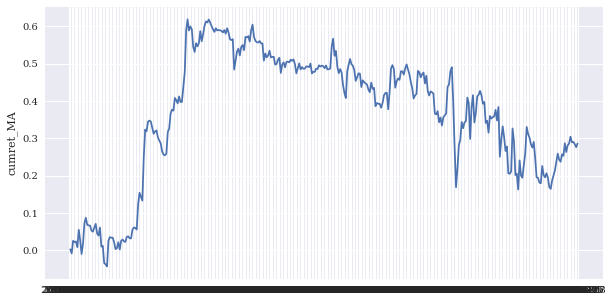

In [38]:
plt.figure(figsize=[10,5])
plt.plot(goodpair['cumret_MA'])
plt.ylabel('cumret_MA')
plt.show()